In [102]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random

from transformer_lens import HookedTransformer

In [2]:
torch.set_grad_enabled(False)

In [3]:
model = HookedTransformer.from_pretrained_no_processing('meta-llama/Llama-3.1-8B', device='cuda')

Loading checkpoint shards: 100%|██████████| 4/4 [01:36<00:00, 24.23s/it]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [4]:

class Grid:
    def __init__(self, words, rows, cols):
        n_words = len(words)
        
        if rows * cols != n_words:
            raise ValueError(f"Grid dimensions ({rows}x{cols}={rows*cols}) do not match number of words ({n_words})")

        self.words = words
        self.rows = rows
        self.cols = cols
        self.grid = np.array(words).reshape(self.rows, self.cols).tolist()

        self.word_to_col = {word: i % cols for i, word in enumerate(words)}
        self.word_to_row = {word: i // cols for i, word in enumerate(words)}

    def generate_sequence(self, seq_len):
        sequence = []

        row, col = np.random.randint(0, self.rows), np.random.randint(0, self.cols)
        sequence.append(self.grid[row][col])

        while len(sequence) < seq_len:
            valid_moves = self._get_valid_moves(row, col)

            direction = np.random.choice(valid_moves)
            if direction == 'up':
                row -= 1
            elif direction == 'down':
                row += 1
            elif direction == 'left':
                col -= 1
            elif direction == 'right':
                col += 1

            sequence.append(self.grid[row][col])

        return sequence
    
    def get_valid_next_words(self, word):
        row, col = self.word_to_row[word], self.word_to_col[word]
        return self._get_valid_next_words_from_position(row, col)
    
    def _get_valid_next_words_from_position(self, row, col):
        valid_moves = self._get_valid_moves(row, col)
        next_words = []
        for move in valid_moves:
            if move == 'up':
                next_words.append(self.grid[row-1][col])
            elif move == 'down':
                next_words.append(self.grid[row+1][col])
            elif move == 'left':
                next_words.append(self.grid[row][col-1])
            elif move == 'right':
                next_words.append(self.grid[row][col+1])
        return next_words
    
    def _get_valid_moves(self, row, col):
        valid_moves = []
        if row > 0: valid_moves.append('up')
        if row < self.rows - 1: valid_moves.append('down')
        if col > 0: valid_moves.append('left')
        if col < self.cols - 1: valid_moves.append('right')
        return valid_moves

In [5]:
words = ['apple', 'bird', 'car', 'egg','house', 'milk', 'plane', 'opera', 'box', 'sand', 'sun', 'mango', 'rock', 'math', 'code', 'phone']

In [6]:
grid = Grid(words, rows=4, cols=4)

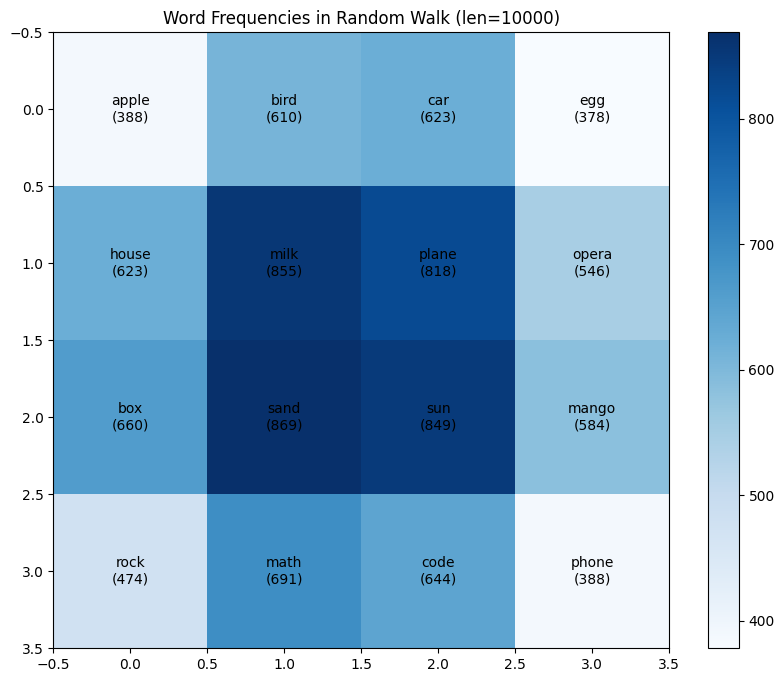

In [7]:
N_STEPS = 10_000

sequence = grid.generate_sequence(N_STEPS)

# histogram of word frequencies:
word_freq = {}
for word in sequence:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

# Create a 2D array of frequencies matching the grid layout
freq_grid = np.zeros((grid.rows, grid.cols))
for i, row in enumerate(grid.grid):
    for j, word in enumerate(row):
        freq_grid[i][j] = word_freq.get(word, 0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(freq_grid, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Add word labels to each cell
for i in range(grid.rows):
    for j in range(grid.cols):
        plt.text(j, i, f'{grid.grid[i][j]}\n({int(freq_grid[i][j])})', 
                ha='center', va='center')
        

plt.title(f'Word Frequencies in Random Walk (len={N_STEPS})')
plt.show()


In [8]:
def tokenize_sequence(sequence: list[str]) -> torch.Tensor:
    sequence_as_string = ' ' + ' '.join(sequence)
    return model.tokenizer(sequence_as_string, return_tensors='pt').input_ids

In [9]:
sequence = grid.generate_sequence(10)

tokens = tokenize_sequence(sequence)
model.to_str_tokens(tokens)

['<|begin_of_text|>',
 ' rock',
 ' box',
 ' rock',
 ' math',
 ' sand',
 ' math',
 ' code',
 ' math',
 ' sand',
 ' box']

## Give it to the model

In [10]:
def run_experiment(sequence_length):
    sequence = grid.generate_sequence(sequence_length)
    tokens = tokenize_sequence(sequence)
    logits = model(tokens.to(model.cfg.device))
    probs = torch.softmax(logits, dim=-1)
    probs = probs[0, 1:, :] # shave off bos token

    accuracies = []

    for i in range(sequence_length):
        valid_next_words = grid.get_valid_next_words(sequence[i])
        valid_next_word_token_ids = torch.tensor([model.tokenizer.encode(' ' + w, add_special_tokens=False) for w in valid_next_words]).squeeze()
        accuracy = probs[i, valid_next_word_token_ids].sum().item()
        accuracies.append(accuracy)

    return accuracies


In [11]:
SEQ_LEN = 1400
ITERS = 20

accuracies = []

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies.append(run_experiment(SEQ_LEN))


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


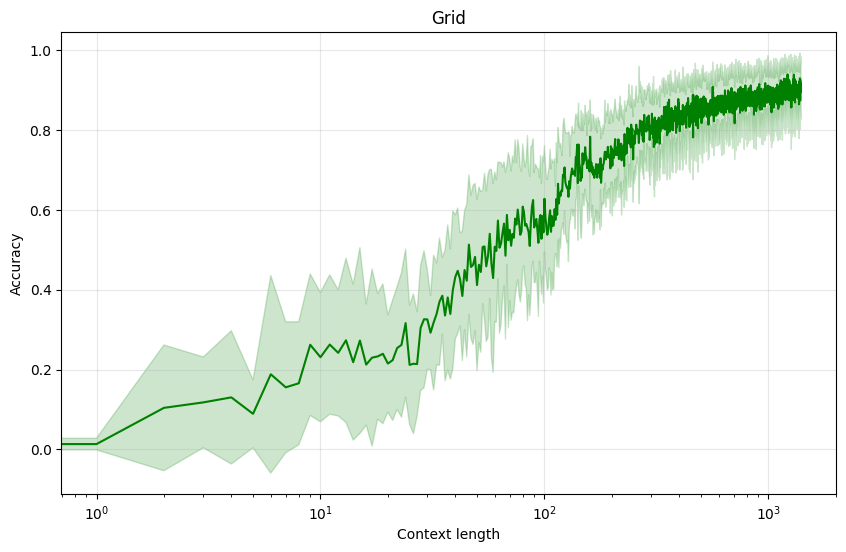

In [12]:
accuracies = np.array(accuracies)
mean = accuracies.mean(axis=0)
std = accuracies.std(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean, label='Mean accuracy', color='green')
plt.fill_between(
    range(len(mean)), 
    mean - std, 
    mean + std, 
    alpha=0.2,
    color='green'
)

plt.xscale('log')
plt.xlabel('Context length')
plt.ylabel('Accuracy')
plt.title('Grid')
plt.grid(True, alpha=0.3)
plt.show()

## Analyze representations

In [145]:
seed = 100
torch.random.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [146]:
layers = [16, 18, 20, 22, 24, 26, 28, 30]

names_filter = [f'blocks.{layer}.hook_resid_pre' for layer in layers]

sequence_length = 2000
n_lookback = 100

sequence = grid.generate_sequence(sequence_length)
tokens = tokenize_sequence(sequence)

logits, cache = model.run_with_cache(tokens.to(model.cfg.device), names_filter=names_filter)

In [147]:
layer = 26
cache_key = f'blocks.{layer}.hook_resid_pre'

words_to_acts = {}
for i in range(sequence_length-n_lookback, sequence_length):
    word = sequence[i]
    if word not in words_to_acts:
        words_to_acts[word] = []
    words_to_acts[word].append(cache[cache_key][0, i, :])

acts_per_word_avgs = []
for word in words_to_acts:
    acts_per_word_avgs.append(torch.mean(torch.stack(words_to_acts[word]), dim=0))
acts_per_word_avgs = torch.stack(acts_per_word_avgs)


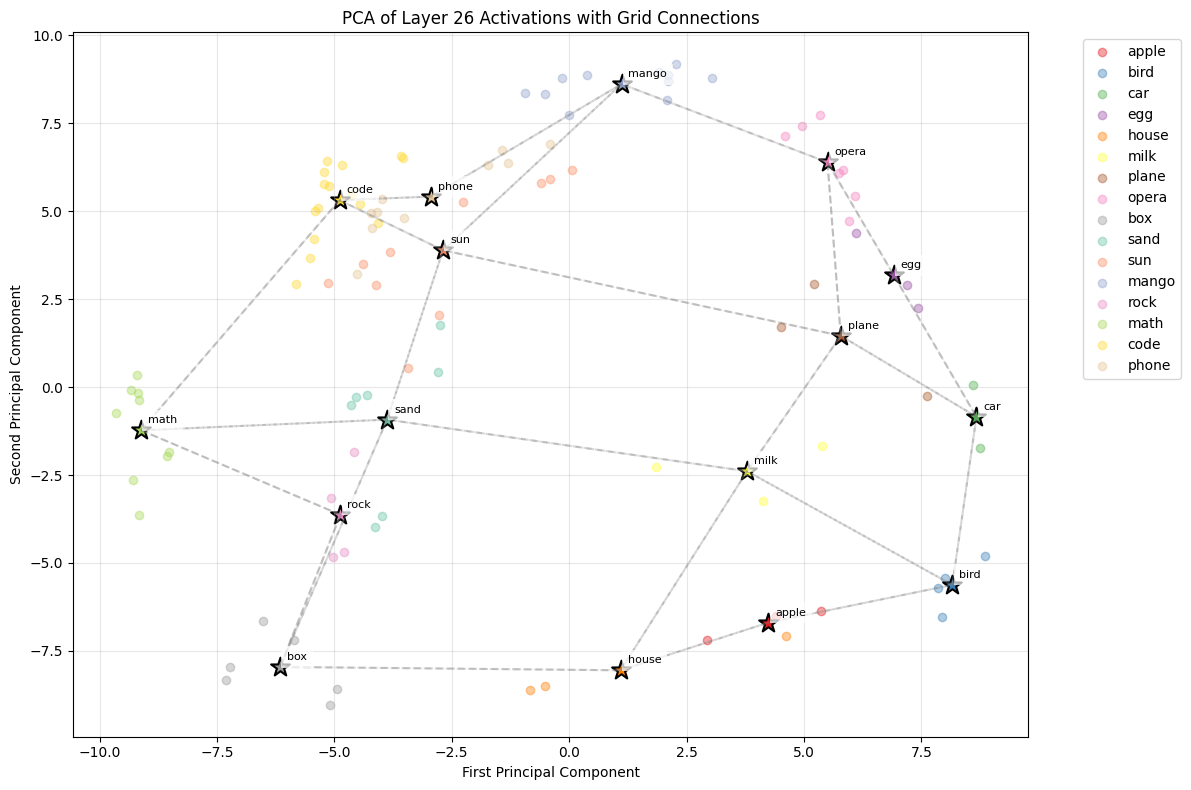

In [148]:
# Center the averaged activations and get PCA directions
acts_per_word_avgs_centered = acts_per_word_avgs - acts_per_word_avgs.mean(dim=0, keepdim=True)
U, S, V = torch.svd(acts_per_word_avgs_centered)
V = V[:, :2]  # Take first two principal components

# Center and project the cached activations
cache_centered = cache[cache_key][0, -n_lookback:, :] - acts_per_word_avgs.mean(dim=0, keepdim=True)
projected = cache_centered @ V


# Create the visualization
plt.figure(figsize=(12, 8))

# Define distinct colors
distinct_colors = [
    '#e41a1c',  # Red
    '#377eb8',  # Blue
    '#4daf4a',  # Green
    '#984ea3',  # Purple
    '#ff7f00',  # Orange
    '#ffff33',  # Yellow
    '#a65628',  # Brown
    '#f781bf',  # Pink
    '#999999',  # Grey
    '#66c2a5',  # Mint
    '#fc8d62',  # Salmon
    '#8da0cb',  # Light Blue
    '#e78ac3',  # Light Pink
    '#a6d854',  # Light Green
    '#ffd92f',  # Gold
    '#e5c494'   # Tan
]

unique_words = grid.words
word_to_color = dict(zip(unique_words, distinct_colors[:len(unique_words)]))

# First, compute and store all average positions
word_to_avg_pos = {}
for word in unique_words:
    word_indices = [i for i, w in enumerate(sequence[-n_lookback:]) if w == word]
    word_points = projected[word_indices]
    word_to_avg_pos[word] = word_points.mean(dim=0).cpu()

# Draw lines between connected words
for word in unique_words:
    # Get valid next words from the grid
    connected_words = grid.get_valid_next_words(word)
    start_pos = word_to_avg_pos[word]
    
    # Draw lines to each connected word
    for next_word in connected_words:
        if next_word in word_to_avg_pos:  # Check if we have data for this word
            end_pos = word_to_avg_pos[next_word]
            plt.plot([start_pos[0], end_pos[0]], 
                    [start_pos[1], end_pos[1]], 
                    color='gray', alpha=0.3, linestyle='--')

# Plot points and averages with annotations
for word in unique_words:
    word_indices = [i for i, w in enumerate(sequence[-n_lookback:]) if w == word]
    word_points = projected[word_indices]
    
    # Plot individual points with higher alpha
    plt.scatter(word_points[:, 0].cpu(), 
                word_points[:, 1].cpu(), 
                color=word_to_color[word],
                alpha=0.4,  # increased from 0.3
                label=word)
    
    # Plot average point
    avg_point = word_to_avg_pos[word]
    plt.scatter(avg_point[0], 
                avg_point[1], 
                color=word_to_color[word],
                s=200,
                marker='*',
                edgecolors='black',
                linewidth=1.5)  # increased edge width
    
    # Add annotation next to star
    plt.annotate(word, 
                (avg_point[0], avg_point[1]),
                xytext=(5, 5),  # 5 points offset
                textcoords='offset points',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title(f'PCA of Layer {layer} Activations with Grid Connections')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Observation:
- Sometimes the graph is really pretty.
- But sometimes it's not.
- Depends on random seed.